# Final Evaluation

In this notebook I will choose the best model for each problem and test it on never before seen data.

NOTE: Since this is a medical testing problem I will make recall the priority metric of performance. Since it is better to tell an healthy person they are ill then to tell an ill person they are well when they could use help.

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

# 1.1 Load Data

In [5]:
# load data from csv
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


train.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,80.111572,33.942432,85.101608,46.169139,125.593624,100.292107,Spondylolisthesis
1,63.404481,14.115327,48.136806,49.289153,111.916008,31.784495,Spondylolisthesis
2,52.419385,19.011561,35.872660,33.407825,116.559771,1.694705,Hernia
3,91.468741,24.508177,84.620272,66.960564,117.307897,52.623047,Spondylolisthesis
4,44.362490,8.945435,46.902096,35.417055,129.220682,4.994195,Normal


# 1.2 One Hot Encode Target Variable

In [6]:
# ohe data
def ohe(df):
    dummies = pd.get_dummies(df["class"], prefix="class_")
    df.drop("class", axis=1, inplace=True)
    df = pd.concat([df, dummies], axis=1)
    
    return df

train = ohe(train)

train.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class__Hernia,class__Normal,class__Spondylolisthesis
0,80.111572,33.942432,85.101608,46.169139,125.593624,100.292107,0,0,1
1,63.404481,14.115327,48.136806,49.289153,111.916008,31.784495,0,0,1
2,52.419385,19.011561,35.872660,33.407825,116.559771,1.694705,1,0,0
3,91.468741,24.508177,84.620272,66.960564,117.307897,52.623047,0,0,1
4,44.362490,8.945435,46.902096,35.417055,129.220682,4.994195,0,1,0


In [7]:
test = ohe(test)

# 2.1 Preprocessing

Here I will seperate the target variables and the features. I will also scale the data.

In [8]:
# seperate independent and dependent variables

# training data
targets = [col for col in train.columns if col.startswith("class")]
X_train = train.drop(targets, axis=1)
y_train_hernia = train["class__Hernia"]
y_train_spond = train["class__Spondylolisthesis"]

# testing data
X_test = test.drop(targets, axis=1)
y_test_hernia = test["class__Hernia"]
y_test_spond = test["class__Spondylolisthesis"]

X_train.shape, X_test.shape, y_train_hernia.shape, y_test_hernia.shape

((279, 6), (31, 6), (279,), (31,))

In [9]:
# scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 3.1 Training

Now I will retrain the models. I will use logistic regression for hernia detection and random forest for spondylolisthesis. The ideal parameters have been previously found.

In [11]:
# hernia
hernia_model = LogisticRegression()

# spondylolisthesis
spond_model = RandomForestClassifier(max_depth=5, n_estimators=50)

In [14]:
# scores
# create a function to print desired scores
scorers = [make_scorer(g) for g in [recall_score, precision_score, accuracy_score]]

def find_scores(clf, X, y, scorers):
    for scorer, score_type in zip(scorers, ["recall", "precision", "accuracy"]):
        print(f"\n\n{score_type}")
        results = cross_validate(clf, X, y, scoring=scorer, cv=4)["test_score"]
        print(results)
        print("avg:", sum(results)/4)
        print("var:", np.array(results).var())


In [15]:
# hernia scores
find_scores(hernia_model, X_train, y_train_hernia, scorers)



recall
[0.71428571 0.64285714 0.53846154 0.61538462]
avg: 0.6277472527472527
var: 0.003960496920661758


precision
[0.71428571 0.9        0.63636364 0.66666667]
avg: 0.7293290043290043
var: 0.010481004385225166


accuracy
[0.88732394 0.91428571 0.85507246 0.86956522]
avg: 0.8815618347767765
var: 0.0004874149485120506


In [16]:
# spondylolithesis scores
find_scores(spond_model, X_train, y_train_spond, scorers)



recall
[0.97058824 0.97058824 1.         0.96969697]
avg: 0.9777183600713013
var: 0.00016562288503150404


precision
[0.91428571 1.         0.94444444 0.94117647]
avg: 0.9499766573295985
var: 0.0009710567233429326


accuracy
[0.95714286 0.98571429 0.97142857 0.95652174]
avg: 0.9677018633540373
var: 0.00014370587554492502


# 3.2 Precision Recall Tradeoff

It should be useful to use the precision recall tradoff with the hernia classifier. As the recall is only %62 on the training set and recall is the most important metric when dealing with medical tests.

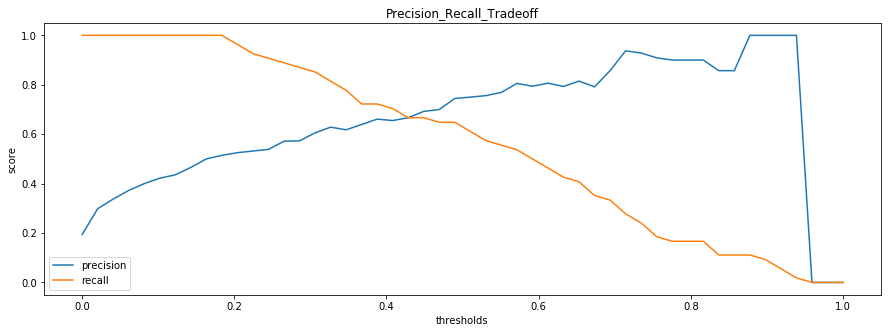

In [30]:
# precision recall trade-off

# fit
hernia_model.fit(X_train, y_train_hernia)

# get probabilities
probs = hernia_model.predict_proba(X_train)[:, 1]

# create thresholds
thresholds = np.linspace(0, 1, 50)

# create new results for each threshold
prec_scores = []
rec_scores = []
for th in thresholds:
    new_results = [0 if p <= th else 1 for p in probs]
    prec_scores.append(precision_score(y_train_hernia, new_results))
    rec_scores.append(recall_score(y_train_hernia, new_results))
    
# plotting
plt.figure(figsize=(15, 5))
plt.plot(thresholds, prec_scores, label="precision")
plt.plot(thresholds, rec_scores, label="recall")
plt.title("Precision_Recall_Tradeoff")
plt.xlabel("thresholds")
plt.ylabel("score")
plt.legend()
plt.show()

It seems like the best tradeoff point is around 0.25

# 4.1 Final Evaluation

Now it is time to test the models on the testing set.

#### Hernia Model

In [31]:
# get probabilities
probs = hernia_model.predict_proba(X_test)[:, 1]

# adjust threshold
results = [0 if p <= 0.25 else 1 for p in probs]

# print scores
print("recall:", recall_score(y_test_hernia, results))
print("precision:", precision_score(y_test_hernia, results))
print("accuracy:", accuracy_score(y_test_hernia, results))

recall: 0.8333333333333334
precision: 0.7142857142857143
accuracy: 0.9032258064516129


##### Spondylolisthesis model

In [33]:
# fit model and get results
spond_model.fit(X_train, y_train_spond)
results = spond_model.predict(X_test)

# print scores
print("recall:", recall_score(y_test_spond, results))
print("precision:", precision_score(y_test_spond, results))
print("accuracy:", accuracy_score(y_test_spond, results))

recall: 1.0
precision: 0.9375
accuracy: 0.967741935483871
